# Customer Segmentation
We must first segment the customers into similar groups in order to target the customers better with personalised product recommendations.

## RFM Segmentation:
Order Items (order_id) must be joined to the Orders (order_id) to get the (customer_id). The (customer_id) of Orders must be joined to Customers.
The sum of price on all the same order_id's (in Order Items CSV), and once joined to orders and customers, we then have the customer_unique_id.
Fit the customers into clusters, then you will have segmented based on RFM values.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

In [2]:
# Load and merge CSV files
items = pd.read_csv("data/olist_order_items_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
customers = pd.read_csv("data/olist_customers_dataset.csv")
geolocation = pd.read_csv("data/olist_geolocation_dataset.csv")
data = pd.merge(items, orders, on="order_id")
data = pd.merge(data, customers, on="customer_id")

## !!! NOTE: Preprocessing from Subtask 1 is required!

In [3]:
# Preprocess data
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)
data = data[data["order_status"] == "delivered"]

## Select RFM features
Recency (of the order), frequency (how many items in the order), monetary (value of the order).

In [4]:
# Select RFM features
data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])
max_date = data["order_purchase_timestamp"].max() # gets the latest purchase
data["recency"] = (max_date - data["order_purchase_timestamp"]).dt.days # days since last purchase 
rfm = data.groupby("customer_unique_id").agg({"order_id": "nunique", "price": "sum", "recency": "min"})
rfm.columns = ["frequency", "monetary", "recency"]

In [5]:
# NOTE: Check that standardising is needed or not.
# Standardise RFM features
# scaler = StandardScaler()
# rfm_scaled = scaler.fit_transform(rfm)
rfm_scaled = rfm
rfm_scaled.head()

,frequency,monetary,recency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,111
0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,114
0000f46a3911fa3c0805444483337064,1,69.00,536
0000f6ccb0745a6a4b88665a16c9f078,1,25.99,320
0004aac84e0df4da2b147fca70cf8255,1,180.00,287


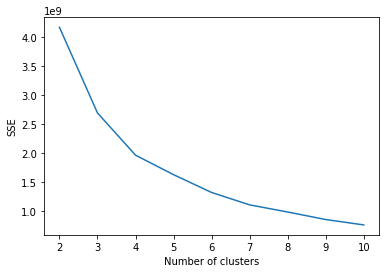

In [6]:
# Determine optimal number of clusters (using elbow method & silhouette score)
sse = [] # sum of squared errors 
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

    # Calculate the silhouette score of the clustering.
    # NOTE: The following lines are commented out due to computational time. The result is in the table below.
#     cluster_labels = kmeans.labels_
#     data_rfm_k = rfm_scaled.assign(Cluster = cluster_labels)
#     print(f'Silhouette Score(k={k}): {silhouette_score(rfm_scaled, cluster_labels)}')

plt.plot(range(2, 11), sse)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

## Silhouette Score
The silhouette score measures the distance between clusters and can determine the effectiveness of the clustering.
The score is between +1 and -1. A positive score indicates seperation between the clusters (good), and a negative score indicates overlapping clusters (bad).

| Cluster (w/o standardising) | Silhouette Score |
| --- | --- |
| 2 | 0.7350307132554209 |
| 3 | 0.4464181643710864 |
| 4 | 0.4674003977327137 |
| 5 | 0.3890712326513849 |
| 6 | 0.4065179623645617 |
| 7 | 0.4124540789458798 |
| 8 | 0.4124748554259864 |
| 9 | 0.4150074415670860 |
| 10 | 0.3693316077587359 |

Conclusion, cluster size of 4 seems to be the best number of clusters.

In [7]:
# Apply K-means clustering using k=4 (based on the elbow method chart and silhouette score)
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm_scaled)
rfm_scaled["cluster"] = kmeans.labels_

# Analyse cluster characteristics
rfm_scaled.groupby("cluster").describe()

frequency                                               monetary  \
            count      mean       std  min  25%  50%  75%   max    count   
cluster                                                                    
0         49996.0  1.029202  0.179529  1.0  1.0  1.0  1.0   5.0  49996.0   
1           744.0  1.088710  0.377969  1.0  1.0  1.0  1.0   5.0    744.0   
2         36710.0  1.024653  0.165765  1.0  1.0  1.0  1.0   6.0  36710.0   
3          5886.0  1.116888  0.471369  1.0  1.0  1.0  1.0  15.0   5886.0   

                      ...                       recency              \
                mean  ...        75%       max    count        mean   
cluster               ...                                             
0          99.413674  ...   139.0000    365.70  49996.0  127.090607   
1        1761.821210  ...  1977.7500  13440.00    744.0  242.034946   
2          99.859098  ...   134.9900    419.90  36710.0  387.493381   
3         555.808865  ...   666.8675   1156.99   5886.0  229.813116   

                                                        
                std    min    25%    50%    75%    max  
cluster                                                 
0         72.525771    0.0   64.0  128.0  189.0  257.0  
1        160.511284    3.0  102.0  229.0  360.0  690.0  
2         95.782747  257.0  300.0  375.0  461.0  713.0  
3        141.324515    0.0  118.0  214.0  317.0  693.0  

[4 rows x 24 columns]

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    111
0000b849f77a49e4a4ce2b2a4ca5be3f    114
0000f46a3911fa3c0805444483337064    536
0000f6ccb0745a6a4b88665a16c9f078    320
0004aac84e0df4da2b147fca70cf8255    287
                                   ... 
fffcf5a5ff07b0908bd4e2dbc735a684    446
fffea47cd6d3cc0a88bd621562a9d061    261
ffff371b4d645b6ecea244b27531430a    567
ffff5962728ec6157033ef9805bacc48    118
ffffd2657e2aad2907e67c3e9daecbeb    483
Name: recency, Length: 93336, dtype: int64


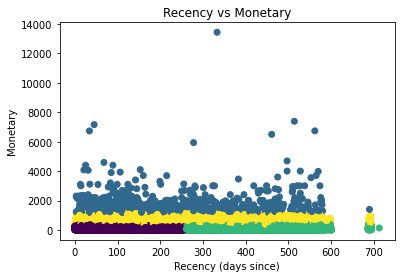

In [8]:
print(rfm_scaled["recency"])

plt.scatter(rfm_scaled["recency"], rfm_scaled["monetary"], c=rfm_scaled["cluster"])
plt.xlabel("Recency (days since)")
plt.ylabel("Monetary")
plt.title("Recency vs Monetary")
plt.show()

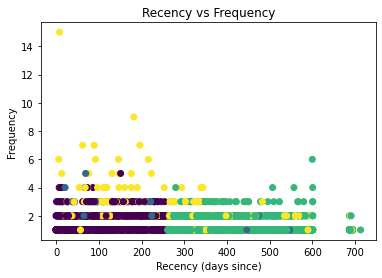

In [9]:
plt.scatter(rfm_scaled["recency"], rfm_scaled["frequency"], c=rfm_scaled["cluster"])
plt.xlabel("Recency (days since)")
plt.ylabel("Frequency")
plt.title("Recency vs Frequency")
plt.show()

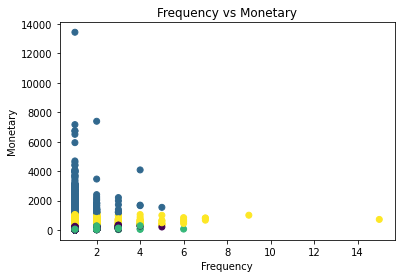

In [10]:
plt.scatter(rfm_scaled["frequency"], rfm_scaled["monetary"], c=rfm_scaled["cluster"])
plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.title("Frequency vs Monetary")
plt.show()

In [11]:
# This will display the mean of the clusters.
print(rfm_scaled.pivot_table(columns=['cluster']))

cluster             0            1           2           3
frequency    1.029202     1.088710    1.024653    1.116888
monetary    99.413674  1761.821210   99.859098  555.808865
recency    127.090607   242.034946  387.493381  229.813116


## Summary of RFM segmentation
* A cluster size of 4 seems most suitable.
* Clusters are ranked from 'worse customer (orders little and not often)' and the 'best customer (high spender, orders frequently)'.

# Feature Engineering segmentation
# CHECK: This might not be needed.
Feature engineering is creating a new variable for segmentation based on existing parameters/variables

In [12]:
# Get the coordinates of each zip code prefix.
geolocation_unique = geolocation.drop_duplicates(subset=['geolocation_zip_code_prefix'], keep='first')

# Merge the zip code coordinates 
customer_coords = pd.merge(customers, geolocation_unique, left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix")

We will now create a new variable called "total_cost" which combines 